In [15]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import scipy.ndimage
from skimage.feature import peak_local_max

img = cv.imread('periodic_noise.JPG', cv.IMREAD_GRAYSCALE)
dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

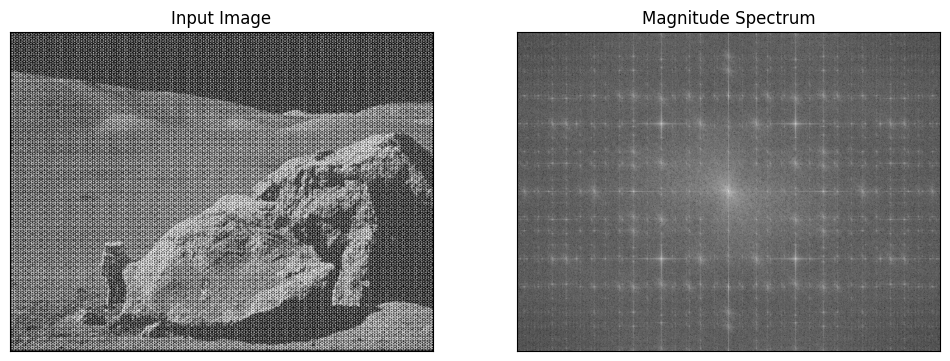

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [145]:
# Параметры
sigma = 40

# Получаем размер изображения
rows, cols = img.shape

# Создаем Гауссово ядро
gauss_kernel = np.zeros((rows, cols, 2), np.float32)

# Вычисляем значения Гауссового ядра
for i in range(rows):
    for j in range(cols):
        distance = np.sqrt((i - rows / 2)**2 + (j - cols / 2)**2)
        gauss_kernel[i, j, :] = np.exp(-distance**2 / (2 * sigma**2))

# Создаем маску высоких частот
highpass_mask = 1 - gauss_kernel

# Применяем Гауссово ядро для фильтрации
dft_shift_filtered_gauss = dft_shift * gauss_kernel

# Обратное преобразование Фурье для получения изображения
f_ishift_gauss = np.fft.ifftshift(dft_shift_filtered_gauss)
img_back_gauss = cv.idft(f_ishift_gauss)
img_back_gauss = cv.magnitude(img_back_gauss[:, :, 0], img_back_gauss[:, :, 1])

# Применяем маску высоких частот для фильтрации
dft_shift_filtered_highpass = dft_shift * highpass_mask

# Обратное преобразование Фурье для получения изображения
f_ishift_highpass = np.fft.ifftshift(dft_shift_filtered_highpass)
img_back_highpass = cv.idft(f_ishift_highpass)
img_back_highpass = cv.magnitude(img_back_highpass[:, :, 0], img_back_highpass[:, :, 1])



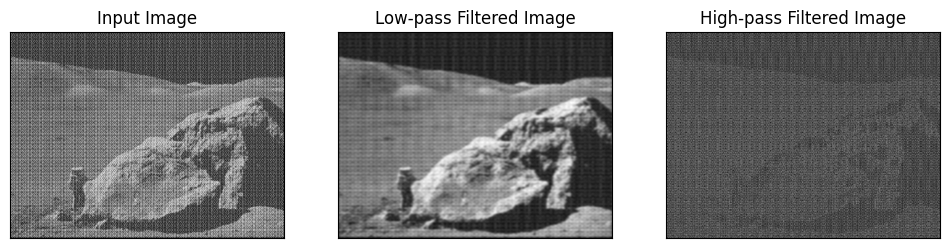

In [146]:
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(img_back_gauss, cmap='gray')
plt.title('Low-pass Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_back_highpass, cmap='gray')
plt.title('High-pass Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [153]:
# Параметры для поиска шума
min_distance = 10
threshold_abs = 270

# Находим координаты пиков в спектре
noise_coords = peak_local_max(magnitude_spectrum, min_distance=min_distance, threshold_abs=threshold_abs)

# Создаем маску для удаления шума
mask_noise = np.ones_like(dft_shift)

# Устанавливаем значения в маске на 0 в зависимости от координат шума
for x, y in noise_coords:
    if x != rows // 2 or y != cols // 2:
        mask_noise[x, :] = 0 if x != rows // 2 else mask_noise[x, :]
        mask_noise[:, y] = 0 if y != cols // 2 else mask_noise[:, y]

# Применяем маску к DFT для удаления шума
dft_shift_denoised = dft_shift * mask_noise

# Обратное преобразование Фурье для получения отфильтрованного изображения
f_ishift_denoised = np.fft.ifftshift(dft_shift_denoised)
img_back_denoised = cv.idft(f_ishift_denoised)

# Получаем величину (модуль) из комплексного изображения
img_back_denoised = cv.magnitude(img_back_denoised[:, :, 0], img_back_denoised[:, :, 1])


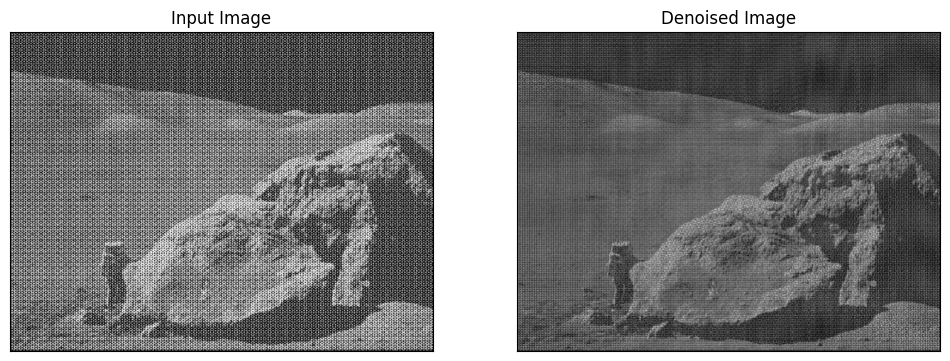

In [154]:
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_back_denoised, cmap='gray')
plt.title('Denoised Image'), plt.xticks([]), plt.yticks([])
plt.show()